# Run Simulations

This notebook defines and runs all of the simulations described in the chapter. It is completely self-contained, as long as the correct python libraries are installed. 

We run the simulations described in the chapter and save the result to file. The `make_figures.ipynb` notebook then plots the results.

The code below is easily modified and adapted to explore different parameter configurations and model specifications. 

It is written to emphasize readability over numerical efficiency, which is fine for presented purposes since run time is not a major bottleneck for the (fast-timescale) phenomena of interest here. Speedups and further optimizations can be easily implemented with e.g. Cython, *jit* compilers (e.g. numba), etc. 


*Run time: approx. 45 minutes.*

## Setup

Importage

In [1]:
# Generic stuff
import warnings; warnings.filterwarnings('ignore') # ugly ugly
import os,numpy as np,pandas as pd
from numpy import exp,sin,cos,sqrt
from scipy.signal import welch,periodogram
from datetime import datetime
from itertools import product
from copy import copy
from joblib import Parallel,delayed

# Visualization stuff
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image

Define some variables

In [6]:
# Folder locations
base_dir = os.getcwd()
code_dir = base_dir + '/code'
data_dir = base_dir + '/data'
figs_dir = base_dir + '/figs'

Now we define the function that specifies the network structure and runs the simulations. 

We integrate the following set of stochastic delay-differential equations, using a simpler forward-stepipng Euler-Maruyma scheme:

\begin{align}  
\frac{d}{dt} \mathbf{u}_e(t) =& - \mathbf{u}_e(t) + g_{ee} \mathbf{F}[\mathbf{u}_e(t)] + g_{ei} \mathbf{F} [ \mathbf{u}_i(t)] + g_{es} \mathbf{F}[\mathbf{u}_s (t - \tau_1)] + g_cc CCI + \mathbf{P}(t) + \sqrt(2D) \mathbf{\xi}_e(t) \\
\frac{d}{dt} \mathbf{u}_i(t) =& - \mathbf{u}_i(t) + g_{ii} \mathbf{F}[\mathbf{u}_i(t)] + g_{ie} \mathbf{F} [ \mathbf{u}_e(t)] + g_{is} \mathbf{F}[\mathbf{u}_s (t - \tau_1)] + \sqrt(2D) \mathbf{\xi}_i(t)   \\
\frac{d}{dt} \mathbf{u}_r(t) =& - \mathbf{u}_r(t) + g_{re} \mathbf{F} [ \mathbf{u}_e (t-\tau_1)] + g_{rs} \mathbf{F} [\mathbf{u_s}(t-\tau_2)] + \sqrt(2D) \mathbf{\xi}_r (t) \\ 
\frac{d}{dt} \mathbf{u}_s(t) =& - \mathbf{u}_s (t) + g_{sr} \mathbf{F} [ \mathbf{u}_r (t-\tau_2)] + g_{se} \mathbf{F} [ \mathbf{u}_e (t-\tau_1) \ + I_o 
\end{align}


where:

- $\mathbf{u}_{e,i,r,s}$ are the state variables describing the activity of the cortical excitatory / cortical inhibitory / thalamic reticular / thalamic speciifc relay neural populations, 
- $g_{ab}$ are gains or connections strengths between each neural populations
- $\mathbf{F}$ is a sigmoidal coupling function
- $\tau_1$ and $\tau_2$ are thalamocortical/corticorticothalamic and intrathalamic delays, respectively
- $\xi$ is a zero-mean Gaussian white noise process with variance $D$


The generali organiation in terms of thalamocortical loop motifs, and application of current stimulation to the cortical nodes, is shown diagramatically in figure 1 of the chapter:

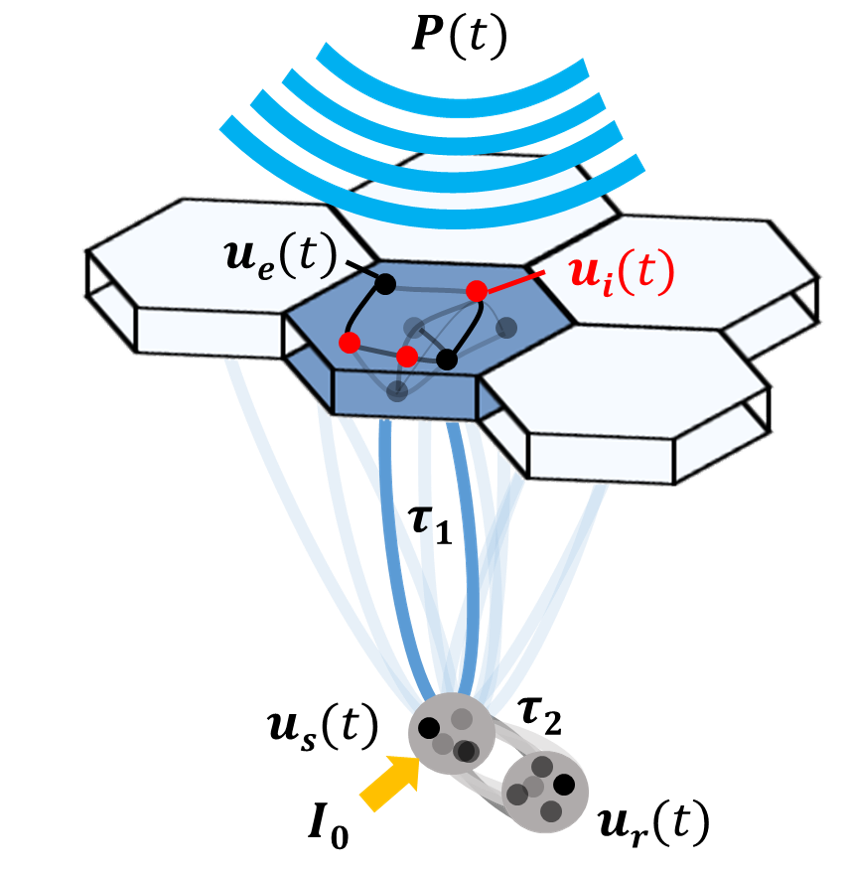

In [7]:
display(Image(figs_dir + '/figure_1.png',width=300));

See the chapter text for further description of this system. 

The simulation function returns simulated time series for each neural population (and for the stimulation waveform), as well as power spectra computed using two the *periodogram* and *Welch* methods, as implemented in `scipy.signal`.

In [8]:
# Notes:
# - time series not returned by default (to avoid memory errors). Will be returned 
#   if return_ts=True
# - freq vs. amp param sweep has default range within which max freqs are calculated 
#   of 5-95 Hz

def run_sim(wee = 0.5,wei = 1.,wie = -2.,wii = -0.5,wertn = 0.6,weth = .6,
            wthi = 0.2,wthe = 1.65,wrtnth = -2.,wthrtn = 2.,D_e = .0001,D_i= .0001,
            D_th = 0.0001,D_rtn = 0.0001,T = 1024,P=1,Q = 1,K = 1,Dt = 0.001,
            dt = 0.1,gain = 20.,threshold = 0.,Pi = 3.14159,g = -0.9,a_e = 0.3,
            a_i = 0.5,a_th = 0.2,a_rtn = 0.2,i_e = -0.35,i_i = -0.3,i_th = 0.5,
            i_rtn = -0.8,tau1  = 20.,tau2 = 5.,I_o = 0,T_transient=1000,
            stim_freq=35.,stim_amp=0.5,return_ts=False,compute_connectivity=False):
    
    n_nodes = K
    
    x1 = n_nodes/2.
    x2 = x1+20.

    # Neuronal response function
    def f(u,gain=gain,threshold=threshold):
        output= 1./(1.+exp(-gain*(u-threshold))); 
        return output 
    
    # Initialize variables
    Xi_e = np.random.uniform(low=-1.,high=1.,size=[K,T+T_transient])
    Xi_i = np.random.uniform(low=-1.,high=1.,size=[K,T+T_transient])
    Xi_th = np.random.uniform(low=-1.,high=1.,size=[K,T+T_transient])
    Xi_rtn = np.random.uniform(low=-1.,high=1.,size=[K,T+T_transient])
    
    e = np.zeros_like(Xi_e) 
    i = np.zeros_like(Xi_i)
    th = np.zeros_like(Xi_th)
    rtn = np.zeros_like(Xi_rtn)
    
    # initialize first state with random variables instead...
    e[:,0] = np.random.randn(n_nodes)
    i[:,0] = np.random.randn(n_nodes)
    th[:,0] = np.random.randn(n_nodes)
    rtn[:,0] = np.random.randn(n_nodes)
    
    # Define time
    Ts = np.arange(0,T+T_transient)
    

    # Define stimulus
    state_input = 1.
    stim = state_input * stim_amp*sin(2*Pi*stim_freq*Ts*Dt)

   
    
    # Integration loop
    
    for t in Ts[:-1]:
        
        Cortico_cortical_input = f(e[:,t]).mean()
        
        # Cortico-cortical connections
        weefe = wee*f(e[:,t])
        wiifi = wii*f(i[:,t])
        wiefi = wie*f(i[:,t])
        weife = wei*f(e[:,t]) 
        gccin = g*Cortico_cortical_input
            
        # Cortico-thalamic connections
        if t<=tau1:
            wethfe=wertnfe=0
        else:
            wethfe = weth*f(e[:,int(t-tau1)]) 
            wertnfe = wertn*f(e[:,int(t-tau1)])
        
        
        # Thalamo-cortical connections
        if t<=tau1:
            wthefth=wthifth=0
        else:
            wthefth = wthe*f(th[:,int(t-tau1)])
            wthifth = wthi*f(th[:,int(t-tau1)])
            
        # Thalamo-thalamic connections
        if t<=tau2:
            wthrtnfth=wrtnthfrtn=0
        else:
            wrtnthfrtn = wrtnth*f(rtn[:,int(t-tau2)])
            wthrtnfth = wthrtn*f(th[:,int(t-tau2)])

            
        # Noise inputs
        e_noise = sqrt(2.*D_e*dt)*Xi_e[:,t]
        i_noise = sqrt(2.*D_i*dt)*Xi_i[:,t]
        th_noise = sqrt(2.*D_th*dt)*Xi_th[:,t]
        rtn_noise = sqrt(2.*D_rtn*dt)*Xi_rtn[:,t]
            
            
        # Collate inputs
        e_inputs = weefe + wiefi + wthefth + gccin + i_e + stim[t]
        i_inputs = weife + wiifi + wthifth + i_i
        th_inputs = wethfe + wrtnthfrtn + I_o + i_th
        rtn_inputs = wthrtnfth + wertnfe+ i_rtn
          
        # d/dt
        e[:,t+1]   = e[:,t]   + dt*a_e*(-e[:,t]     + e_inputs)   + e_noise
        i[:,t+1]   = i[:,t]   + dt*a_i*(-i[:,t]     + i_inputs)   + i_noise
        th[:,t+1]  = th[:,t]  + dt*a_th*(-th[:,t]   + th_inputs)  + th_noise
        rtn[:,t+1] = rtn[:,t] + dt*a_rtn*(-rtn[:,t] + rtn_inputs) + rtn_noise

            

    # Concatenate sim time series
    df_all = pd.concat({'e': pd.DataFrame(e.T[T_transient:]),
                        'i': pd.DataFrame(i.T[T_transient:]),
                        'th':pd.DataFrame(th.T[T_transient:]),
                        'rtn': pd.DataFrame(rtn.T[T_transient:]),
                        'stim': pd.DataFrame(stim.T[T_transient:])},axis=1)
    df_all.index = (Ts[T_transient:]-T_transient)*(Dt*1000.)

    # Compute power spectra:
    
    # 1. Welch's method
    tmp = welch(df_all.T,fs= 1./Dt) 
    df_wel = pd.DataFrame(tmp[1].T,index=tmp[0])
    df_wel.columns = df_all.columns
    
    # 2. Periodogram
    tmp = periodogram(df_all.T,fs= 1./Dt) 
    df_per = pd.DataFrame(tmp[1].T,index=tmp[0])
    df_per.columns = df_all.columns
    

    # this is necessary to stop memory error crashes
    if return_ts==False: df_all=None
    
    return df_all,df_wel,df_per

Now run the simulations!

First we do some individual runs, and save the full time series outputs for visualization in the next notebook. 

Then, we do some longer-running parameter sweeps, and keep only the spectral data. 

## Single exemplary parameter set sim runs

No stim

In [9]:
sim_rest_nostim = run_sim(I_o=0.,K=100,stim_amp=0.,return_ts=True)
sim_rest_nostim_ts,_,sim_rest_nostim_psd = sim_rest_nostim

sim_task_nostim = run_sim(I_o=1.5,K=100,stim_amp=0.,return_ts=True)
sim_task_nostim_ts,_,sim_task_nostim_psd = sim_task_nostim

Stim 27 Hz

In [10]:
sim_rest_stim27Hz = run_sim(I_o=0.,K=100,stim_amp=0.5,stim_freq=27.,return_ts=True)
sim_rest_stim27Hz_ts,_,sim_rest_stim27Hz_psd = sim_rest_stim27Hz

sim_task_stim27Hz = run_sim(I_o=1.5,K=100,stim_amp=0.5,stim_freq=27.,return_ts=True)
sim_task_stim27Hz_ts,_,sim_task_stim27Hz_psd = sim_task_stim27Hz

Save to file

In [11]:
sim_rest_nostim_ts.to_hdf(data_dir + '/sim_singlepsets_rest.hdf', 'sim_rest_nostim_ts')
sim_rest_nostim_psd.to_hdf(data_dir + '/sim_singlepsets_rest.hdf', 'sim_rest_nostim_psd')

sim_rest_stim27Hz_ts.to_hdf(data_dir + '/sim_singlepsets_rest.hdf', 'sim_rest_stim27Hz_ts')
sim_rest_stim27Hz_psd.to_hdf(data_dir + '/sim_singlepsets_rest.hdf', 'sim_rest_stim27Hz_psd')

In [12]:
sim_task_nostim_ts.to_hdf(data_dir + '/sim_singlepsets_task.hdf', 'sim_task_nostim_ts')
sim_task_nostim_psd.to_hdf(data_dir + '/sim_singlepsets_task.hdf', 'sim_task_nostim_psd')

sim_task_stim27Hz_ts.to_hdf(data_dir + '/sim_singlepsets_task.hdf', 'sim_task_stim27Hz_ts')
sim_task_stim27Hz_psd.to_hdf(data_dir + '/sim_singlepsets_task.hdf', 'sim_task_stim27Hz_psd')

## Stim amplitude vs. Stim frequency parameter space sim runs

Define some `joblib` wrappers for the `run_sim` function that allow us to easily parallelize the simulation runs:

In [13]:
def pse_par(paramslist,sim_func=run_sim,n_jobs=2,temp_folder = '/tmp'):
    
    # Run parallel sims
    sim_res = Parallel(n_jobs=n_jobs,temp_folder=temp_folder)\
             (delayed(sim_func)(**p)\
             for p in paramslist)

    return sim_res       


def FreqVsAmpPsweep(fixed_params,freqs,amps,n_jobs=2,verbose=True,
                    temp_folder='/tmp',outfile=None,outpfx=None,
                    concat_res=False,return_ts=False,peak_freq_range=[5,95],
                    compute_connectivity=False):
    
    pfr = peak_freq_range
    
    if verbose == True:
        start = datetime.now()
        print 'started: %s' %start
        
    # Set up params list
    combs = list(product(freqs,amps))
    paramslist = []
    for f,a in combs:
        newparams = copy(fixed_params)
        newparams['stim_freq'] = f
        newparams['stim_amp'] = a
        newparams['return_ts'] = return_ts
        newparams['compute_connectivity'] = compute_connectivity
        paramslist.append(newparams)

    # Run parallel sims
    sim_res = pse_par(paramslist,sim_func = run_sim,n_jobs=n_jobs,
                      temp_folder=temp_folder)
    
    # Assemble outputs
    _all_dat,_all_wel,_all_per = {},{},{}
    for (f,a),(dat,wel,per) in zip(combs,sim_res):
        _all_dat[f,a] = dat
        _all_wel[f,a] = wel
        _all_per[f,a] = per
 
    # added in this option because getting memory error if the param space is too big 
    if concat_res == False:
        res_dict = dict(_all_dat=_all_dat,_all_per=_all_per,_all_wel=_all_wel,paramslist=paramslist)
    else:
        
        if return_ts == True:
            all_dat = pd.concat(_all_dat)
            all_dat.index.names = ['stim_freq', 'stim_amp', 't']
            all_dat.columns.names = ['pop', 'region']
        else:
            all_dat = None
            
        all_wel = pd.concat(_all_wel)
        all_wel.index.names = ['stim_freq', 'stim_amp','Hz']
        all_wel.columns.names = ['pop', 'region']

        all_per = pd.concat(_all_per)
        all_per.index.names = ['stim_freq','stim_amp', 'Hz']
        all_per.columns.names = ['pop', 'region']
        
        all_wel_maxfreqs = all_wel.unstack(['stim_freq','stim_amp']).loc[pfr[0]:pfr[1]]\
                                  .idxmax().unstack('region').mean(axis=1).unstack('pop')
        
        all_wel_maxamps = all_wel.unstack(['stim_freq', 'stim_amp']).loc[pfr[0]:pfr[1]]\
                                 .unstack('region').mean(axis=1).unstack('pop')
    
        all_per_maxfreqs = all_per.unstack(['stim_freq','stim_amp']).loc[pfr[0]:pfr[1]]\
                               .idxmax().unstack('region').mean(axis=1).unstack('pop')
        
        all_per_maxamps = all_per.unstack(['stim_freq', 'stim_amp']).loc[pfr[0]:pfr[1]]\
                              .max().unstack('region').mean(axis=1).unstack('pop')

        res_dict = dict(all_dat=all_dat,all_per=all_per,all_wel=all_wel,
                        all_wel_maxfreqs=all_wel_maxfreqs,
                        all_wel_maxamps=all_wel_maxamps,
                        all_per_maxfreqs=all_per_maxfreqs,
                        all_per_maxamps=all_per_maxamps)

    
    if verbose == True:
        
        finish = datetime.now()
        dur = str(finish - start)
        print 'finished: %s' %finish
        print 'duration: %s' %dur
        
        
    
    return res_dict

Run parameter sweep for the 'rest' parameter ranges

In [14]:
freqs = np.arange(0,100,1)
amps = np.arange(0.,2.05,0.05)
fixed_params = {'I_o': 0., 'K':10}
sim_rest_psweep = FreqVsAmpPsweep(fixed_params,freqs,amps,n_jobs=4,concat_res=False)

started: 2018-04-17 17:29:08.559189
finished: 2018-04-17 17:37:47.587972
duration: 0:08:39.028783


Collate results and save to file

In [15]:
tmp = pd.concat(sim_rest_psweep['_all_per'])['e'].mean(axis=1)
tmp.index.names = ['stim_freq','stim_amp', 'Hz']
tmp = tmp.unstack(['stim_freq', 'stim_amp']).idxmax().unstack('stim_freq')
sim_rest_psweep_maxfreqs = tmp

tmp = pd.concat(sim_rest_psweep['_all_per'])['e'].mean(axis=1)
tmp.index.names = ['stim_freq','stim_amp', 'Hz']
tmp = tmp.unstack(['stim_freq', 'stim_amp']).max().unstack('stim_freq')
sim_rest_psweep_maxamps = tmp

sim_rest_psweep_maxfreqs.to_hdf(data_dir + '/sim_psweeps_rest.hdf', 'sim_rest_psweep_maxfreqs')
sim_rest_psweep_maxamps.to_hdf(data_dir + '/sim_psweeps_rest.hdf', 'sim_rest_psweep_maxamps')

Now run parameter seep for the 'task' parameter ranges

In [16]:
freqs = np.arange(0,100,1)
amps = np.arange(0.,1.01,0.01)
fixed_params = {'I_o': 1.5, 'K':10}
sim_task_psweep = FreqVsAmpPsweep(fixed_params,freqs,amps,n_jobs=4,concat_res=False)

started: 2018-04-17 17:37:59.303612
finished: 2018-04-17 17:59:27.977484
duration: 0:21:28.673872


Collate and save to file again.

In [18]:
tmp = pd.concat(sim_task_psweep['_all_per'])['e'].mean(axis=1)
tmp.index.names = ['stim_freq','stim_amp', 'Hz']
tmp = tmp.unstack(['stim_freq', 'stim_amp']).idxmax().unstack('stim_freq')
sim_task_psweep_maxfreqs = tmp

tmp = pd.concat(sim_task_psweep['_all_per'])['e'].mean(axis=1)
tmp.index.names = ['stim_freq','stim_amp', 'Hz']
tmp = tmp.unstack(['stim_freq', 'stim_amp']).max().unstack('stim_freq')
sim_task_psweep_maxamps = tmp

sim_task_psweep_maxfreqs.to_hdf(data_dir + '/sim_psweeps_task.hdf', 'sim_task_psweep_maxfreqs')
sim_task_psweep_maxamps.to_hdf(data_dir + '/sim_psweeps_task.hdf', 'sim_task_psweep_maxamps')

Good! We have now run all of our simulations, and can move on to the next notebook where we plot the results and generate the figures shown in the chapter. 